In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bowler = pd.read_csv('/content/drive/MyDrive/American Expres Campus Challenge 2024/Dataset/663e2b2c60743_bowler_level_scorecard.csv')
batsman = pd.read_csv('/content/drive/MyDrive/American Expres Campus Challenge 2024/Dataset/663e2b548c98c_batsman_level_scorecard.csv')
train = pd.read_csv('/content/drive/MyDrive/American Expres Campus Challenge 2024/Dataset/663e2b6d54457_train_data_with_samplefeatures.csv')
matchlevel = pd.read_csv('/content/drive/MyDrive/American Expres Campus Challenge 2024/Dataset/664389efa0868_match_level_scorecard.csv')
submit = pd.read_csv('/content/drive/MyDrive/American Expres Campus Challenge 2024/Dataset/6644a1e287df6_test_data_with_samplefeatures.csv')

In [ ]:
!pip install ydata-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 24.4 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=1302d3f7b86bd0966dcd848448c15f2a1e3f1ba43608122e809a7a69dd34bee0
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(train, title='Pandas Profiling Report for train', explorative=True)
profile.to_notebook_iframe()

In [ ]:
profile = ProfileReport(matchlevel, title='Pandas Profiling Report for match level', explorative=True)
profile.to_notebook_iframe()

In [ ]:
profile = ProfileReport(batsman, title='Pandas Profiling Report for batsman', explorative=True)
profile.to_notebook_iframe()

In [ ]:
profile = ProfileReport(bowler, title='Pandas Profiling Report for bowler', explorative=True)
profile.to_notebook_iframe()

In [ ]:
# train['match_dt'] = pd.to_datetime(train['match_dt'])

In [ ]:
def get_last_10_games(team, current_date, match_data):
    # Ensure match_date column is in datetime format
    match_data['match_dt'] = pd.to_datetime(match_data['match_dt'])
    current_date = pd.to_datetime(current_date)

    # Filter matches where the given team participated and played before or on the current date
    team_matches = match_data[((match_data['team1'] == team) | (match_data['team2'] == team)) & (match_data['match_dt'] < current_date)]

    # Sort matches by date in descending order and take the last 10 matches
    team_matches = team_matches.sort_values(by='match_dt', ascending=False).head(10)

    return team_matches['match id'].tolist()
def calculate_average_runs_top_batsman(team, match_ids, batsman_data, match_data):
    team_match_ids = match_data[(match_data['match id'].isin(match_ids)) &
                                ((match_data['team1'] == team) | (match_data['team2'] == team))]['match id']
    team_data = batsman_data[batsman_data['match id'].isin(team_match_ids)]
    if not team_data.empty:
        top_batsman = team_data.groupby('batsman')['runs'].sum().idxmax()
        avg_runs_top_1 = team_data[team_data['batsman'] == top_batsman].groupby('match id')['runs'].mean().mean()
        return avg_runs_top_1
    return 0

def calculate_average_runs_top_batsmen(team, match_ids, batsman_data, match_data):
    team_match_ids = match_data[(match_data['team1'] == team) | (match_data['team2'] == team) & (match_data['match id'].isin(match_ids))]['match id']
    team_data = batsman_data[batsman_data['match id'].isin(team_match_ids)]
    top_batsmen = team_data.groupby('batsman')['runs'].sum().nlargest(3).index
    avg_runs_top_3 = team_data[team_data['batsman'].isin(top_batsmen)].groupby('match id')['runs'].sum().mean()
    return avg_runs_top_3

def calculate_average_strike_rate_top_batsman(team, match_ids, batsman_data, match_data):
    team_match_ids = match_data[(match_data['team1'] == team) | (match_data['team2'] == team) & (match_data['match id'].isin(match_ids))]['match id']
    team_data = batsman_data[batsman_data['match id'].isin(team_match_ids)]

    if team_data.empty:
        return 0.0

    top_batsman = team_data.groupby('batsman')['runs'].sum().idxmax()
    top_batsman_data = team_data[team_data['batsman'] == top_batsman]
    total_runs = top_batsman_data['runs'].sum()
    total_balls_faced = top_batsman_data['balls_faced'].sum()

    if total_balls_faced == 0:
        return 0.0

    return (total_runs / total_balls_faced) * 100

def calculate_captain_performance(team, match_ids, batsman_data, bowler_data, match_data):
    team_match_ids = match_data[(match_data['match id'].isin(match_ids)) &
                                ((match_data['team1'] == team) | (match_data['team2'] == team))]['match id']
    captain_data = batsman_data[(batsman_data['match id'].isin(team_match_ids)) & (batsman_data['is_batsman_captain'] == 1)]
    if not captain_data.empty:
        avg_runs_captain = captain_data.groupby('match id')['runs'].mean().mean()
        captain_name = captain_data['batsman'].unique()[0]
        captain_bowling_data = bowler_data[(bowler_data['bowler'] == captain_name) & (bowler_data['match id'].isin(team_match_ids))]
        avg_wickets_captain = captain_bowling_data['wicket_count'].mean() if not captain_bowling_data.empty else 0
        avg_bowling_points = avg_wickets_captain * 25
    else:
        avg_runs_captain = 0
        avg_bowling_points = 0
    return avg_runs_captain + avg_bowling_points

def calculate_team_strike_rate(team, match_ids, batsman_data, match_data):
    team_match_ids = match_data[(match_data['team1'] == team) | (match_data['team2'] == team) & (match_data['match id'].isin(match_ids))]['match id']
    team_data = batsman_data[batsman_data['match id'].isin(team_match_ids)]
    total_runs = team_data['runs'].sum()
    total_balls = team_data['balls_faced'].sum()
    if total_balls > 0:
        strike_rate = (total_runs / total_balls) * 100
    else:
        strike_rate = 0
    return strike_rate

def calculate_average_strike_rate_top_batsman(team, match_ids, batsman_data, match_data):
    team_match_ids = match_data[(match_data['team1'] == team) | (match_data['team2'] == team) & (match_data['match id'].isin(match_ids))]['match id']
    team_data = batsman_data[batsman_data['match id'].isin(team_match_ids)]

    if team_data.empty:
        return 0.0

    top_batsman = team_data.groupby('batsman')['runs'].sum().idxmax()
    top_batsman_data = team_data[team_data['batsman'] == top_batsman]
    total_runs = top_batsman_data['runs'].sum()
    total_balls_faced = top_batsman_data['balls_faced'].sum()

    if total_balls_faced == 0:
        return 0.0

    return (total_runs / total_balls_faced) * 100

def calculate_average_wickets_top_bowlers(team, match_ids, bowler_data, match_data):
    team_match_ids = match_data[(match_data['team1'] == team) | (match_data['team2'] == team) & (match_data['match id'].isin(match_ids))]['match id']
    team_data = bowler_data[bowler_data['match id'].isin(team_match_ids)]
    top_bowlers = team_data.groupby('bowler')['wicket_count'].sum().nlargest(3).index
    avg_wickets_top_3 = team_data[team_data['bowler'].isin(top_bowlers)].groupby('match id')['wicket_count'].sum().mean()
    return avg_wickets_top_3

def calculate_average_wickets_top_bowler(team, match_ids, bowler_data, match_data):
    team_match_ids = match_data[(match_data['match id'].isin(match_ids)) &
                                ((match_data['team1'] == team) | (match_data['team2'] == team))]['match id']
    team_data = bowler_data[bowler_data['match id'].isin(team_match_ids)]
    if not team_data.empty:
        top_bowler = team_data.groupby('bowler')['wicket_count'].sum().idxmax()
        avg_wickets_top_1 = team_data[team_data['bowler'] == top_bowler].groupby('match id')['wicket_count'].mean().mean()
        return avg_wickets_top_1
    return 0

def calculate_average_economy(team, match_ids, bowler_data, match_data):
    team_match_ids = match_data[(match_data['match id'].isin(match_ids)) &
                                ((match_data['team1'] == team) | (match_data['team2'] == team))]['match id']
    team_data = bowler_data[bowler_data['match id'].isin(team_match_ids)]
    if not team_data.empty:
        avg_economy = team_data.groupby('match id')['economy'].mean().mean()
        return avg_economy
    return 0

def calculate_economy_top_bowler(team, match_ids, bowler_data, match_data):
    team_match_ids = match_data[(match_data['match id'].isin(match_ids)) &
                                ((match_data['team1'] == team) | (match_data['team2'] == team))]['match id']
    team_data = bowler_data[bowler_data['match id'].isin(team_match_ids)]
    if not team_data.empty:
        top_bowler = team_data.groupby('bowler')['economy'].mean().idxmin()
        economy_top_bowler = team_data[team_data['bowler'] == top_bowler].groupby('match id')['economy'].mean().mean()
        return economy_top_bowler
    return 0

def calculate_average_dot_balls(team, match_ids, bowler_data, match_data):
    team_match_ids = match_data[(match_data['match id'].isin(match_ids)) &
                                ((match_data['team1'] == team) | (match_data['team2'] == team))]['match id']
    team_data = bowler_data[bowler_data['match id'].isin(team_match_ids)]
    if not team_data.empty:
        avg_dot_balls = team_data.groupby('match id')['dots'].mean().mean()
        return avg_dot_balls
    return 0

def calculate_average_freebies(team, match_ids, bowler_data, match_data):
    team_match_ids = match_data[(match_data['match id'].isin(match_ids)) &
                                ((match_data['team1'] == team) | (match_data['team2'] == team))]['match id']
    team_data = bowler_data[bowler_data['match id'].isin(team_match_ids)]
    if not team_data.empty:
        avg_freebies = (team_data.groupby('match id')['noballs'].mean().mean() + team_data.groupby('match id')['wides'].mean().mean())
        return avg_freebies
    return 0

def calculate_average_boundary_conceded(team, match_ids, bowler_data, match_data):
    team_match_ids = match_data[(match_data['match id'].isin(match_ids)) &
                                ((match_data['team1'] == team) | (match_data['team2'] == team))]['match id']
    team_data = bowler_data[bowler_data['match id'].isin(team_match_ids)]
    if not team_data.empty:
        avg_boundaries_conceded = (team_data.groupby('match id')['Fours'].mean().mean() + team_data.groupby('match id')['Sixes'].mean().mean())
        return avg_boundaries_conceded
    return 0

def add_features_to_train(train_data, match_data, batsman_data, bowler_data):
    features_list = []
    for index, row in train_data.iterrows():
        match_id = row['match id']
        team1 = row['team1']
        team2 = row['team2']
        current_date = row['match_dt']

        match_ids_team1 = get_last_10_games(team1, current_date, match_data)
        match_ids_team2 = get_last_10_games(team2, current_date, match_data)

        features_team1 = {
            'avg_runs_top_3_team1': calculate_average_runs_top_batsmen(team1, match_ids_team1, batsman_data, match_data),
            'avg_runs_top_1_team1': calculate_average_runs_top_batsman(team1, match_ids_team1, batsman_data, match_data),
            'captain_performance_team1': calculate_captain_performance(team1, match_ids_team1, batsman_data, bowler_data, match_data),
            'avg_strike_rate_team1': calculate_team_strike_rate(team1, match_ids_team1, batsman_data, match_data),
            'avg_strike_rate_top_batsman_team1': calculate_average_strike_rate_top_batsman(team1, match_ids_team1, batsman_data, match_data),
            'avg_wickets_top_3_team1': calculate_average_wickets_top_bowlers(team1, match_ids_team1, bowler_data, match_data),
            'avg_wickets_top_1_team1': calculate_average_wickets_top_bowler(team1, match_ids_team1, bowler_data, match_data),
            'avg_economy_team1': calculate_average_economy(team1, match_ids_team1, bowler_data, match_data),
            'economy_top_bowler_team1': calculate_economy_top_bowler(team1, match_ids_team1, bowler_data, match_data),
            'avg_dot_balls_team1': calculate_average_dot_balls(team1, match_ids_team1, bowler_data, match_data),
            'avg_freebies_team1': calculate_average_freebies(team1, match_ids_team1, bowler_data, match_data),
            'avg_boundaries_conceded_team1': calculate_average_boundary_conceded(team1, match_ids_team1, bowler_data, match_data)
        }

        features_team2 = {
            'avg_runs_top_3_team2': calculate_average_runs_top_batsmen(team2, match_ids_team2, batsman_data, match_data),
            'avg_runs_top_1_team2': calculate_average_runs_top_batsman(team2, match_ids_team2, batsman_data, match_data),
            'captain_performance_team2': calculate_captain_performance(team2, match_ids_team2, batsman_data, bowler_data, match_data),
            'avg_strike_rate_team2': calculate_team_strike_rate(team2, match_ids_team2, batsman_data, match_data),
            'avg_strike_rate_top_batsman_team2': calculate_average_strike_rate_top_batsman(team2, match_ids_team2, batsman_data, match_data),
            'avg_wickets_top_3_team2': calculate_average_wickets_top_bowlers(team2, match_ids_team2, bowler_data, match_data),
            'avg_wickets_top_1_team2': calculate_average_wickets_top_bowler(team2, match_ids_team2, bowler_data, match_data),
            'avg_economy_team2': calculate_average_economy(team2, match_ids_team2, bowler_data, match_data),
            'economy_top_bowler_team2': calculate_economy_top_bowler(team2, match_ids_team2, bowler_data, match_data),
            'avg_dot_balls_team2': calculate_average_dot_balls(team2, match_ids_team2, bowler_data, match_data),
            'avg_freebies_team2': calculate_average_freebies(team2, match_ids_team2, bowler_data, match_data),
            'avg_boundaries_conceded_team2': calculate_average_boundary_conceded(team2, match_ids_team2, bowler_data, match_data)
        }

        features = {**features_team1, **features_team2}

        # Calculate the differences between teams for the relevant features
        features['diff_avg_runs_top_3'] = features['avg_runs_top_3_team1'] * features['avg_runs_top_3_team2']
        features['diff_avg_runs_top_1'] = features['avg_runs_top_1_team1'] * features['avg_runs_top_1_team2']
        features['diff_captain_performance'] = features['captain_performance_team1'] * features['captain_performance_team2']
        features['diff_avg_strike_rate'] = features['avg_strike_rate_team1'] * features['avg_strike_rate_team2']
        features['diff_avg_strike_rate_top_batsman'] = features['avg_strike_rate_top_batsman_team1'] * features['avg_strike_rate_top_batsman_team2']
        features['diff_avg_wickets_top_3'] = features['avg_wickets_top_3_team1'] * features['avg_wickets_top_3_team2']
        features['diff_avg_wickets_top_1'] = features['avg_wickets_top_1_team1'] * features['avg_wickets_top_1_team2']
        features['diff_avg_economy'] = features['avg_economy_team1'] * features['avg_economy_team2']
        features['diff_economy_top_bowler'] = features['economy_top_bowler_team1'] * features['economy_top_bowler_team2']
        features['diff_avg_dot_balls'] = features['avg_dot_balls_team1'] * features['avg_dot_balls_team2']
        features['diff_avg_freebies'] = features['avg_freebies_team1'] * features['avg_freebies_team2']
        features['diff_avg_boundaries_conceded'] = features['avg_boundaries_conceded_team1'] * features['avg_boundaries_conceded_team2']

        features_list.append(features)

    features_df = pd.DataFrame(features_list)
    train_data_with_features = pd.concat([train_data, features_df], axis=1)

    return train_data_with_features

In [ ]:
# # Print column names for each DataFrame
# print("Train Data Columns:", train.columns)
# print("Match Level Data Columns:", matchlevel.columns)
# print("Batsman Data Columns:", batsman.columns)
# print("Bowler Data Columns:", bowler.columns)


In [ ]:
train_data_with_features = add_features_to_train(train, matchlevel, batsman, bowler)

In [ ]:
train_data_with_features

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,diff_captain_performance,diff_avg_strike_rate,diff_avg_strike_rate_top_batsman,diff_avg_wickets_top_3,diff_avg_wickets_top_1,diff_avg_economy,diff_economy_top_bowler,diff_avg_dot_balls,diff_avg_freebies,diff_avg_boundaries_conceded
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634,Hl Ph,...,2490.160714,12495.209767,12820.512821,10.130952,1.928571,48.483960,8.750,78.787331,0.371429,6.946938
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20,Wt Is,...,565.440000,18623.106383,21818.368107,5.276557,3.200000,65.877667,2.865,55.697849,0.520238,9.333348
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576,Ne,...,993.855000,18912.401762,22659.960552,5.750000,3.851852,81.797008,6.000,36.344350,0.397785,12.428269
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084,Ga An Ws,...,939.360000,15341.116241,18444.667671,7.736842,2.280000,67.743555,0.000,60.526082,0.925303,8.564600
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341,Gt Ts,...,513.375000,17553.961984,19695.110427,8.398551,2.470000,73.744775,13.500,56.285551,0.802007,13.426041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,9128601,Pb Ks,30407,2789079.0:197658.0:2398346.0:2827327.0:2082044...,Ci Sr Ks,30414,7422673.0:249087.0:3519011.0:5001170.0:232000....,Pb Ks,30407,Ci Sr Ks,...,429.352500,18259.971901,19404.847998,5.612308,1.440000,71.032295,0.000,57.837135,0.886982,10.252410
944,9433241,Mx,8700,4421689.0:7752989.0:1941743.0:4489722.0:767287...,St,9701,6139370.0:7694581.0:3294444.0:3239102.0:632036...,St,9701,St,...,1670.527500,18457.590231,20472.831470,6.085227,1.500000,77.823034,24.750,39.191636,0.467030,10.273836
945,9097227,Bd,22497,4239773.0:1941743.0:3007969.0:4172972.0:155625...,Wn Pe,23869,323049.0:4876122.0:4164978.0:1837205.0:3373138...,Wn Pe,23869,Bd,...,0.000000,12980.152832,15757.099170,11.666667,0.000000,0.000000,0.000,0.000000,0.000000,0.000000
946,9516695,Rn Rs,30428,8058959.0:2162782.0:2981614.0:4690188.0:212569...,Ss Hd,36014,5958840.0:7491294.0:3127354.0:3057312.0:420349...,Ss Hd,36014,Rn Rs,...,859.740000,18880.416982,19283.580932,6.705882,0.990000,81.000777,14.875,57.164595,0.870369,15.023825


In [ ]:
# submit['team1only_avg_runs_last15'].fillna(submit['team1only_avg_runs_last15'].mean(), inplace=True)
# submit['ground_avg_runs_last15'].fillna(submit['ground_avg_runs_last15'].mean(), inplace=True)

In [ ]:
submit_data_with_features = add_features_to_train(submit, matchlevel, batsman, bowler)

In [ ]:
train_data_with_features['avg_economy_team1']

0      7.475895
1      8.917703
2      8.772575
3      8.589971
4      9.224971
         ...   
943    9.224971
944    9.514149
945    7.900209
946    9.157229
947    8.675068
Name: avg_economy_team1, Length: 948, dtype: float64

In [ ]:
train_data_with_features.head()

In [ ]:
train_data_with_features.to_csv('train_data_with_features.csv', index = False)

In [ ]:
for column, dtype in train_data_with_features.dtypes.items():
    print(f"{column}: {dtype}")

In [ ]:
train_data_with_features.columns

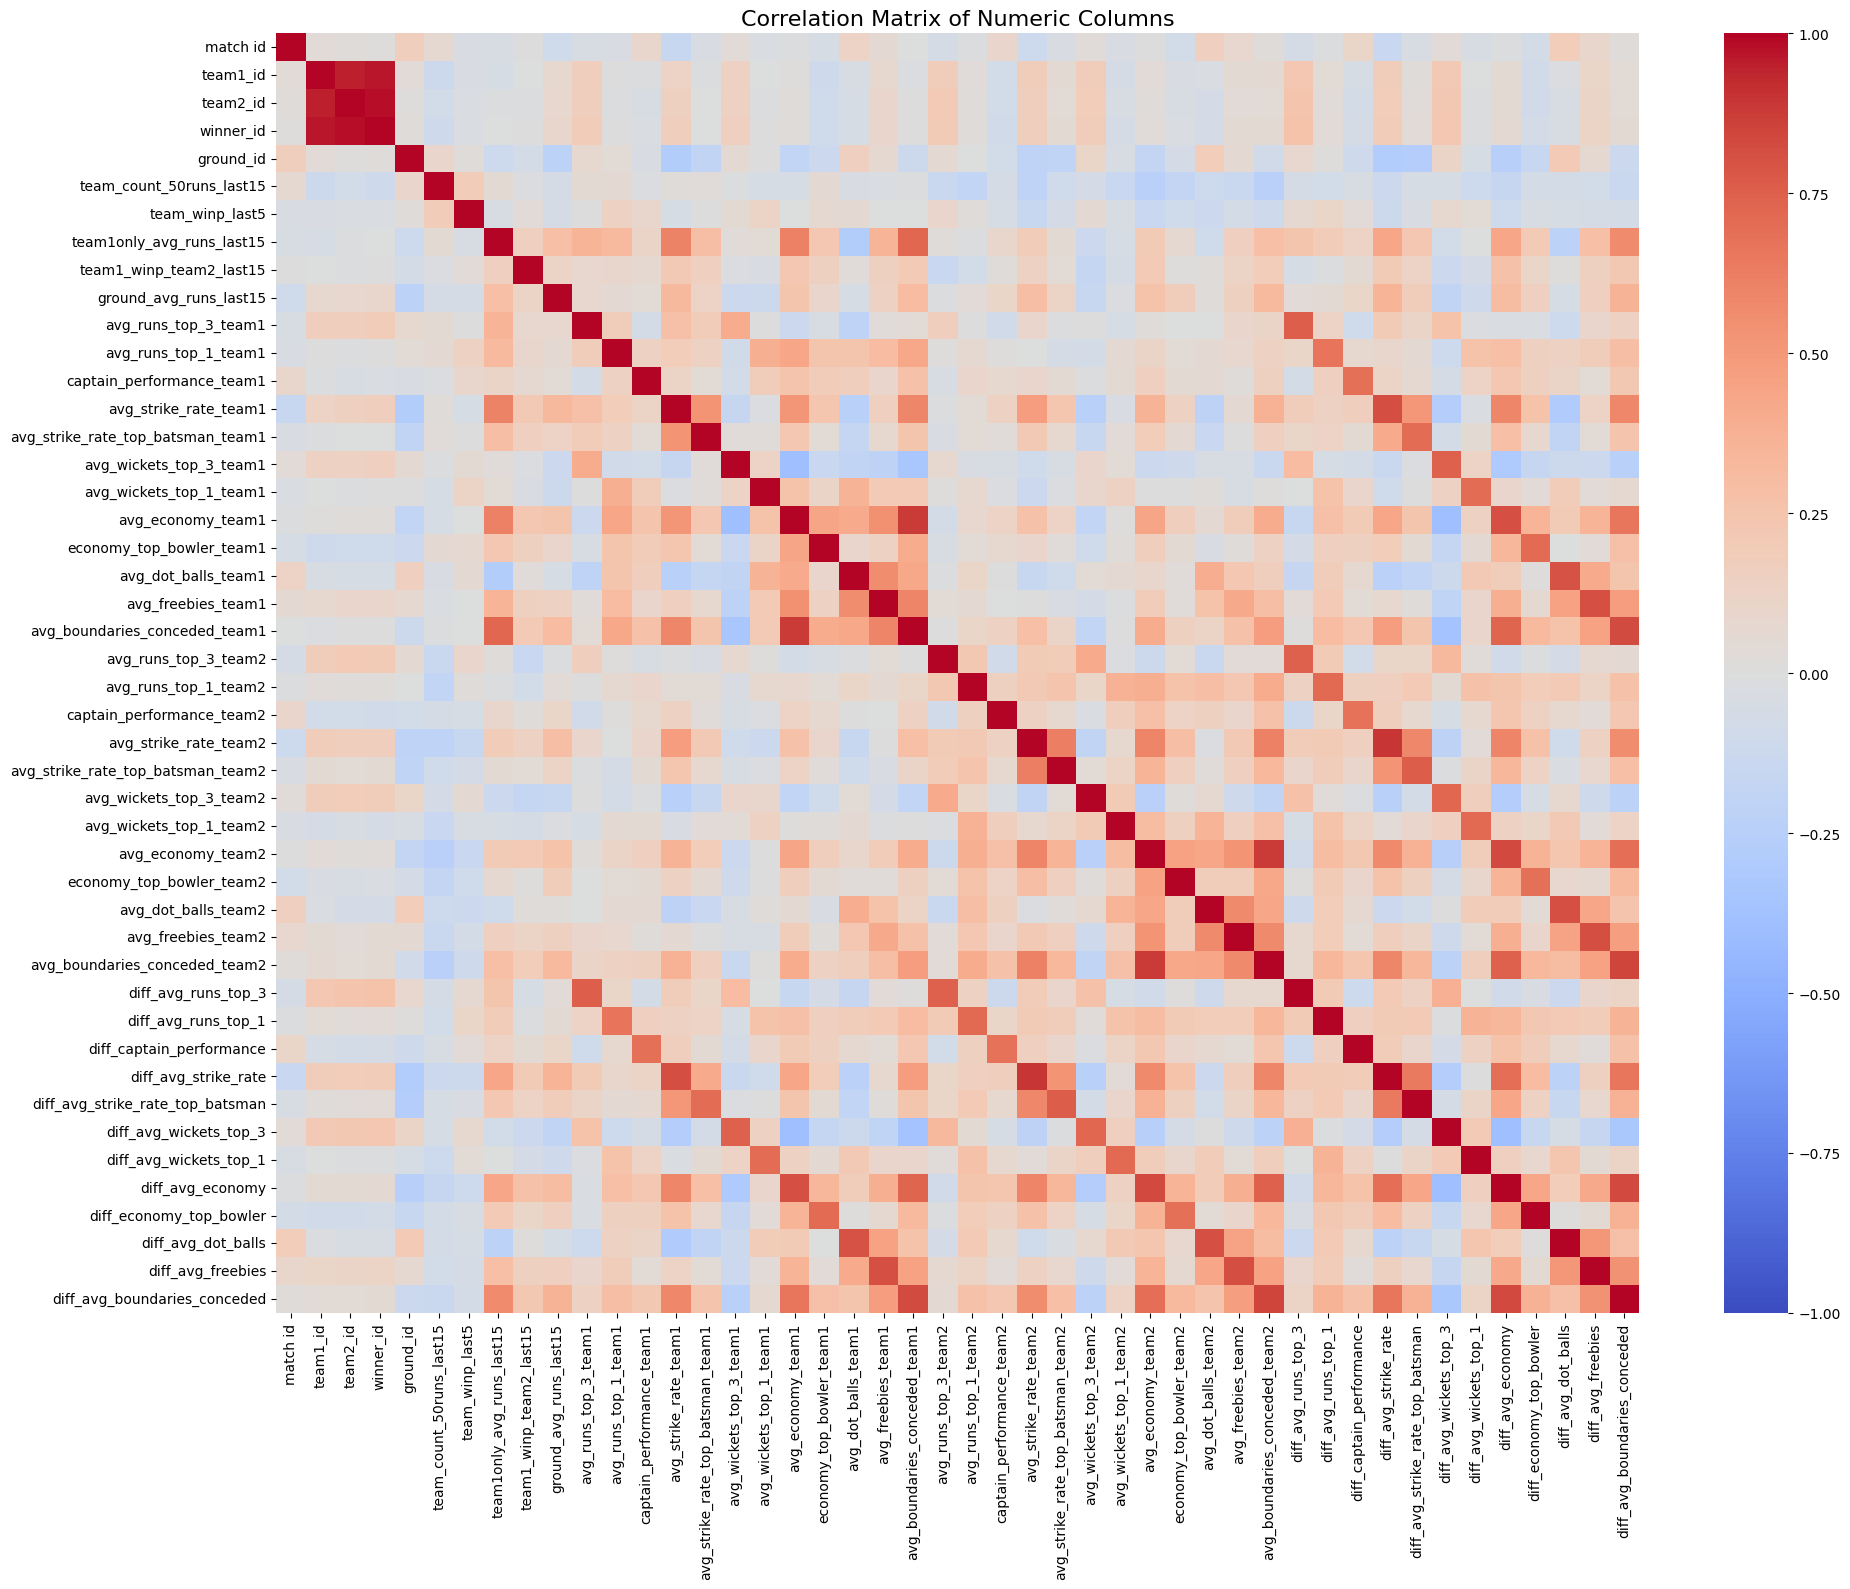

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
numeric_df = train_data_with_features.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
train_data_with_features['winner'] = np.where(train_data_with_features['winner_id'] == train_data_with_features['team1_id'], 0, np.where(train_data_with_features['winner_id'] == train_data_with_features['team2_id'], 1, np.nan))
train_data_with_features = train_data_with_features.sort_values(by='match_dt', ascending=True)
X = train_data_with_features.drop(columns=['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2', 'team2_id', 'team2_roster_ids', 'winner', 'winner_id'])
y = train_data_with_features['winner']

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
split_index = int(len(train_data_with_features) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [ ]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [ ]:
# X_train_preprocessed_dense = X_train_preprocessed.toarray()
# X_test_preprocessed_dense = X_test_preprocessed.toarray()

# pca = PCA(n_components=15, random_state=42)
# numeric_indices = [list(X.columns).index(col) for col in numeric_features]

# X_train_pca = pca.fit_transform(X_train_preprocessed[:, numeric_indices])
# X_test_pca = pca.transform(X_test_preprocessed[:, numeric_indices])


In [ ]:
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler(feature_range=(-1, 1)))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [ ]:
models = {
    'GBM': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42),
    'CatBoost': cb.CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)
}


In [ ]:
best_model = None
best_accuracy = 0
results = {}

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = clf

In [ ]:
print(f"Best Model: {best_model}")
print(f"Best Accuracy: {best_accuracy}")
print("All Results:", results)

Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler(feature_range=(-1,
                                                                                               1)))]),
                                                  Index(['ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'avg_runs_top_3_team1',
       'avg_runs_top_1_team1...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraint

In [ ]:
from sklearn.ensemble import StackingClassifier
from itertools import combinations
model_combinations = []
for r in range(2, len(models) + 1):
    model_combinations.extend(combinations(models.items(), r))

best_model = None
best_accuracy = 0
results = {}

for combination in model_combinations:
    estimators = [(name, model) for name, model in combination]
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=GradientBoostingClassifier(n_estimators=100, random_state=42),
        passthrough=True
    )
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', stack)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_names = ' + '.join([name for name, _ in combination])
    results[model_names] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model_names

print(f"Best Model Combination: {best_model}")
print(f"Best Accuracy: {best_accuracy}")
print("All Results:")
for combo, acc in results.items():
    print(f"{combo}: {acc}")

[LightGBM] [Info] Number of positive: 379, number of negative: 379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8902
[LightGBM] [Info] Number of data points in the train set: 758, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [ ]:

import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier


gbm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])
lgbm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(n_estimators=100, random_state=42))
])
catboost_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', cb.CatBoostClassifier(n_estimators=100, random_state=42, verbose = 0))
])

ensemble_model = VotingClassifier(estimators=[
    ('gbm', gbm_model),
    ('xgboost', xgb_model)
], voting='soft')

ensemble_model.fit(X_train, y_train)

y_pred_test = ensemble_model.predict(X_test)
y_pred_proba_test = ensemble_model.predict_proba(X_test)[:, 1]

In [ ]:
y_pred_train = ensemble_model.predict(X_train)
y_pred_proba_train = ensemble_model.predict_proba(X_train)[:, 1]

In [ ]:
from sklearn.feature_selection import mutual_info_classif
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
feature_names = (numeric_features.tolist() +
                 preprocessor.named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())
mi_scores = mutual_info_classif(X_train_preprocessed, y_train)
top_10_features_indices = np.argsort(mi_scores)[-10:]
top_10_features = [feature_names[i] for i in top_10_features_indices]

# lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
# lgb_model.fit(X_train_preprocessed, y_train)


# y_pred = lgb_model.predict(X_test_preprocessed)
# y_pred_proba = lgb_model.predict_proba(X_test_preprocessed)[:, 1]
primary_submission_train = pd.DataFrame({
    'match_id': train_data_with_features.loc[X_train.index, 'match id'],
    'dataset_type': 'train',
    'win_pred_team_id': np.where(y_pred_train == 0, train_data_with_features.loc[X_train.index, 'team1_id'], train_data_with_features.loc[X_train.index, 'team2_id']),
    'win_pred_score': y_pred_proba_train,
    'train_algorithm': 'lightgbm;xgboost;catboost;gbm',
    'is_ensemble': 'yes',
    'train_hps_trees': 100,
    'train_hps_depth': 8,
    'train_hps_lr': 0.1,
})

for feature in top_10_features:
    if feature in X_train.columns:
        primary_submission_train[feature] = X_train[feature].values
    else:
        original_feature = feature.split('_')[0]
        primary_submission_train[feature] = X_train[original_feature].values
    primary_submission_train[feature] = X_train[feature].values

primary_submission_test = pd.DataFrame({
    'match_id': train_data_with_features.loc[X_test.index, 'match id'],
    'dataset_type': 'train',
    'win_pred_team_id': np.where(y_pred_test == 0, train_data_with_features.loc[X_test.index, 'team1_id'], train_data_with_features.loc[X_test.index, 'team2_id']),
    'win_pred_score': y_pred_proba_test,
    'train_algorithm': 'lightgbm;xgboost;catboost;gbm',
    'is_ensemble': 'yes',
    'train_hps_trees': 100,
    'train_hps_depth': 8,
    'train_hps_lr': 0.1,
})

for feature in top_10_features:
    if feature in X_test.columns:
        primary_submission_test[feature] = X_test[feature].values
    else:
        original_feature = feature.split('_')[0]
        primary_submission_test[feature] = X_test[original_feature].values
    primary_submission_test[feature] = X_test[feature].values


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

In [ ]:
X_submit = submit_data_with_features.drop(columns=['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2', 'team2_id', 'team2_roster_ids'])

submit_pred = ensemble_model.predict(X_submit)
submit_pred_proba = ensemble_model.predict_proba(X_submit)[:, 1]


primary_submission_submit = pd.DataFrame({
    'match_id': submit_data_with_features.loc[X_submit.index, 'match id'],
    'dataset_type': 'r1',
    'win_pred_team_id': np.where(submit_pred == 0, submit_data_with_features.loc[X_submit.index, 'team1_id'], submit_data_with_features.loc[X_submit.index, 'team2_id']),
    'win_pred_score': submit_pred_proba,
    'train_algorithm': 'lightgbm;xgboost;catboost;gbm',
    'is_ensemble': 'yes',
    'train_hps_trees': 100,
    'train_hps_depth': 8,
    'train_hps_lr': 0.1,
})

for feature in top_10_features:
    if feature in X_submit.columns:
        primary_submission_submit[feature] = X_submit[feature].values
    else:
        original_feature = feature.split('_')[0]
        primary_submission_submit[feature] = X_submit[original_feature].values
    primary_submission_submit[feature] = X_submit[feature].values

In [ ]:
primary_submission = pd.concat([primary_submission_train, primary_submission_test, primary_submission_submit], ignore_index=True)

primary_submission.to_csv('AMEX_Round1_primary_submission_Asateer_3.csv', index=False)
primary_submission

,match_id,dataset_type,win_pred_team_id,win_pred_score,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr,diff_avg_freebies,diff_avg_dot_balls,diff_avg_economy,avg_boundaries_conceded_team1,avg_dot_balls_team1,avg_economy_team1,diff_avg_strike_rate_top_batsman,avg_strike_rate_team2,diff_avg_runs_top_3,diff_avg_strike_rate
0,8887675,train,33921,0.049850,lightgbm;xgboost;catboost;gbm,yes,100,8,0.1,0.579240,46.240217,67.048867,3.041492,7.580932,8.188655,16046.191496,129.832636,3475.601190,16757.320125
1,8887689,train,33935,0.012734,lightgbm;xgboost;catboost;gbm,yes,100,8,0.1,0.579002,42.362004,73.023193,3.082251,6.542537,8.702973,20030.619346,128.957029,5378.031818,16965.357463
2,8887703,train,33942,0.979436,lightgbm;xgboost;catboost;gbm,yes,100,8,0.1,0.453716,44.905469,66.109879,3.194139,6.681851,8.380491,18021.674458,125.583658,4559.094118,16208.454360
3,8887717,train,33914,0.983742,lightgbm;xgboost;catboost;gbm,yes,100,8,0.1,0.520241,40.765960,65.754426,2.802298,6.365276,8.087760,14261.385381,126.232143,3654.628571,16275.495741
4,8887731,train,33942,0.987775,lightgbm;xgboost;catboost;gbm,yes,100,8,0.1,0.475626,53.635329,64.107718,3.231702,7.869744,8.254397,17686.844941,124.602626,3384.615942,16210.829174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,9094371,r1,46752,0.650365,lightgbm;xgboost;catboost;gbm,yes,100,8,0.1,0.234119,28.229818,78.576836,2.636247,5.641142,8.593526,22821.797682,142.290306,3136.437500,19262.244152
1215,9440500,r1,55,0.699793,lightgbm;xgboost;catboost;gbm,yes,100,8,0.1,0.537924,53.913101,69.963924,2.680231,6.954782,7.941597,20466.149631,134.788231,4383.166667,16311.496482
1216,9085173,r1,9967,0.295667,lightgbm;xgboost;catboost;gbm,yes,100,8,0.1,0.327789,40.511450,80.565894,3.373578,6.263077,8.953146,19279.940073,137.064826,3351.612698,19226.802439
1217,8887752,r1,33942,0.680469,lightgbm;xgboost;catboost;gbm,yes,100,8,0.1,0.473924,43.863861,67.187609,3.022611,6.672611,8.507678,19782.991284,124.246639,4036.038647,16938.348906


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

X_all = pd.concat([X_train, X_test, X_submit], ignore_index=True)

X_all_preprocessed_df = pd.DataFrame(X_all_preprocessed.toarray(), columns=feature_names)

X_train_preprocessed = X_all_preprocessed_df.iloc[:len(X_train)]

ensemble_model.fit(X_train_preprocessed, y_train)

feature_importances = ensemble_model.feature_importances_


In [ ]:

def calculate_correlation_with_target(feature_name):
    if feature_name in numeric_features:
        return X_train[feature_name].corr(y_train)
    return np.nan

array([0.01413384, 0.02612554, 0.01768428, ..., 0.02618399, 0.        ,
       0.        ], dtype=float32)

In [ ]:
submit_data_with_features.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'toss winner', 'toss decision', 'venue',
       'city', 'match_dt', 'lighting', 'series_name', 'season', 'ground_id',
       'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'avg_runs_top_3_team1',
       'avg_runs_top_1_team1', 'captain_performance_team1',
       'avg_strike_rate_team1', 'avg_strike_rate_top_batsman_team1',
       'avg_wickets_top_3_team1', 'avg_wickets_top_1_team1',
       'avg_economy_team1', 'economy_top_bowler_team1', 'avg_dot_balls_team1',
       'avg_freebies_team1', 'avg_boundaries_conceded_team1',
       'avg_runs_top_3_team2', 'avg_runs_top_1_team2',
       'captain_performance_team2', 'avg_strike_rate_team2',
       'avg_strike_rate_top_batsman_team2', 'avg_wickets_top_3_team2',
       'avg_wickets_top_1_team2', 'avg_economy_team2',
       'economy_top_bowler_

In [ ]:
common_features = ['team1_winp_team2_last15', 'team1only_avg_runs_last15',
            'ground_avg_runs_last15', 'team_count_50runs_last15', 'team_winp_last5',
            'avg_runs_top_3_team1', 'avg_runs_top_1_team1', 'captain_performance_team1',
            'avg_strike_rate_team1', 'avg_strike_rate_top_batsman_team1',
            'avg_wickets_top_3_team1', 'avg_wickets_top_1_team1', 'avg_economy_team1',
            'economy_top_bowler_team1', 'avg_dot_balls_team1', 'avg_freebies_team1',
            'avg_boundaries_conceded_team1', 'avg_runs_top_3_team2', 'avg_runs_top_1_team2',
            'captain_performance_team2', 'avg_strike_rate_team2',
            'avg_strike_rate_top_batsman_team2', 'avg_wickets_top_3_team2',
            'avg_wickets_top_1_team2', 'avg_economy_team2', 'economy_top_bowler_team2',
            'avg_dot_balls_team2', 'avg_freebies_team2', 'avg_boundaries_conceded_team2',
            'diff_avg_runs_top_3', 'diff_avg_runs_top_1', 'diff_captain_performance',
            'diff_avg_strike_rate', 'diff_avg_strike_rate_top_batsman', 'diff_avg_wickets_top_3',
            'diff_avg_wickets_top_1', 'diff_avg_economy', 'diff_economy_top_bowler',
            'diff_avg_dot_balls', 'diff_avg_freebies', 'diff_avg_boundaries_conceded']


In [ ]:
feature_corrs

In [ ]:
feature_corrs = {feature: calculate_correlation_with_target(feature.split('_')[0]) for feature in common_features}

filtered_importances = [importance for feature, importance in zip(feature_names, feature_importances) if feature in common_features]

feature_id = range(1, 42)
secondary_submission = pd.DataFrame({
    'feature_id': feature_id,
    'feature_name': list(common_features),
    'feature_description': list(common_features),
    'model_feature_importance_rank': pd.Series(filtered_importances).rank(ascending=False),
    'model_feature_importance_percentage': np.array(filtered_importances) / sum(filtered_importances) * 100
})

secondary_submission

,feature_id,feature_name,feature_description,model_feature_importance_rank,model_feature_importance_percentage
0,1,team1_winp_team2_last15,team1_winp_team2_last15,1.0,4.043780
1,2,team1only_avg_runs_last15,team1only_avg_runs_last15,9.0,2.737220
2,3,ground_avg_runs_last15,ground_avg_runs_last15,7.0,2.913590
3,4,team_count_50runs_last15,team_count_50runs_last15,40.0,1.426235
4,5,team_winp_last5,team_winp_last5,19.0,2.432412
5,6,avg_runs_top_3_team1,avg_runs_top_3_team1,10.0,2.699850
6,7,avg_runs_top_1_team1,avg_runs_top_1_team1,31.0,1.969861
7,8,captain_performance_team1,captain_performance_team1,27.0,2.219802
8,9,avg_strike_rate_team1,avg_strike_rate_team1,13.0,2.635164
9,10,avg_strike_rate_top_batsman_team1,avg_strike_rate_top_batsman_team1,5.0,3.288105


In [ ]:
secondary_submission.to_csv('AMEX_Round1_secondary_submission_Asateer 3.csv', index=False)